<p style="font-size:11px;"><em><strong>Créditos</strong>: El contenido de este cuaderno ha sido tomado de varias fuentes, pero especialmente de <a href="https://github.com/mmaelicke/scikit-gstat">Scikit GStat</a>, <a href="http://darribas.org/">Dani Arribas-Bel</a> - University of Liverpool & <a href="http://spatial.ucr.edu/peopleRey.html">Sergio Rey</a> - Center for Geospatial Sciences, University of California, Riverside. El compilador se disculpa por cualquier omisión involuntaria y estaría encantado de agregar un reconocimiento.</em></p>

# Kriging con Python

El tipo de análisis estadístico espacial que trata con variables de campo continuo se denomina **geoestadística**. La geoestadística se centra en la descripción de la variación espacial en un conjunto de valores observados y en su predicción en ubicaciones no muestreadas. La idea básica de la geoestadística es describir y estimar las correlaciones espaciales en un conjunto de datos puntuales. Aunque la herramienta principal, el variograma, es bastante fácil de implementar y usar, subyacen muchas suposiciones.

La aplicación típica de la geoestadística es la interpolación. Por lo tanto, aunque se utilicen datos puntuales, un concepto básico es entender estos datos puntuales como una muestra de una variable continua (espacialmente) que puede describirse como un campo aleatorio, o para ser más precisos, como un campo aleatorio gaussiano en muchos casos. La suposición más fundamental en geoestadística es que dos valores xi y xi+h son más similares cuanto más pequeño sea h, que es una distancia de separación en el campo aleatorio. En otras palabras, los puntos de observación cercanos mostrarán mayores covarianzas que los puntos distantes. En caso de que esta suposición conceptual fundamental no se cumpla para una variable específica, la geoestadística no será la herramienta correcta para analizar e interpolar dicha variable.

A veces, todo lo que tenemos disponible es un conjunto de puntos con mediciones de la variable de interés que no coinciden con los puntos para los que queremos la información. En esta situación, una solución en la que podemos confiar es la **interpolación espacial**. Para un campo geográfico continuo medido en un conjunto de puntos, los métodos de "interpolación espacial" nos proporcionan una forma de estimar el valor que tomaría un campo en sitios donde no hemos realizado mediciones.

Existen muchas herramientas de interpolación disponibles, pero generalmente estas herramientas se pueden agrupar en dos categorías: métodos determinísticos y métodos de interpolación.

## Métodos determinísticos

### Interpolación por proximidad
Fue introducido por Alfred H. Thiessen hace más de un siglo. El objetivo es simple: asignar a todas las ubicaciones no muestreadas el valor de la ubicación muestreada más cercana. Esto genera una superficie teselada donde se conectan líneas que dividen el punto medio entre cada ubicación muestreada, encerrando así un área. Cada área termina rodeando un punto de muestra cuyo valor hereda.

<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-proximity-1.png" width="1000"></center>

In [1]:
from sklearn.neighbors import KNeighborsRegressor
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
airbnbs = gpd.read_file("https://geographicdata.science/book/_downloads/dcd429d1761a2d0efdbc4532e141ba14/regression_db.geojson")
airbnbs.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)


<Axes: >

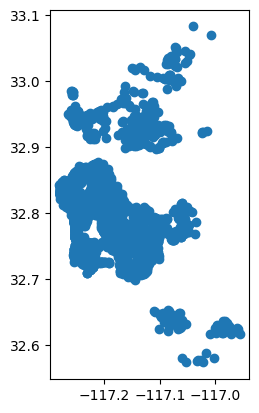

In [3]:
airbnbs.plot()

In [4]:
two_bed_homes = airbnbs[airbnbs['bedrooms']==2 & airbnbs['rt_Entire_home/apt']]
two_bed_homes.head(2)

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
25,2,1.0,0.0,1.0,Pacific Beach,1,13.517509,1,60.0,4.094345,132966,1,0,0,0,0,1,0,0,POINT (-117.25840 32.80855)
26,2,1.0,0.0,1.0,Ocean Beach,0,9.588707,1,99.0,4.595120,141523,1,0,0,0,0,1,0,0,POINT (-117.24684 32.75057)


In [5]:
two_bed_home_locations = np.column_stack((two_bed_homes.geometry.x, two_bed_homes.geometry.y))
two_bed_home_locations[0:10,:]

array([[-117.25839672,   32.80854653],
       [-117.24683514,   32.75057048],
       [-117.15283799,   32.75173354],
       [-117.25159972,   32.76473873],
       [-117.24471021,   32.74097711],
       [-117.2518276 ,   32.93523019],
       [-117.14405391,   32.70807602],
       [-117.1434337 ,   32.74946806],
       [-117.13906285,   32.71533892],
       [-117.12865252,   32.71993986]])

In [6]:
xmin, ymin, xmax, ymax = airbnbs.total_bounds
x, y = np.meshgrid(np.linspace(xmin, xmax, num=50), np.linspace(ymin,ymax, num=50))

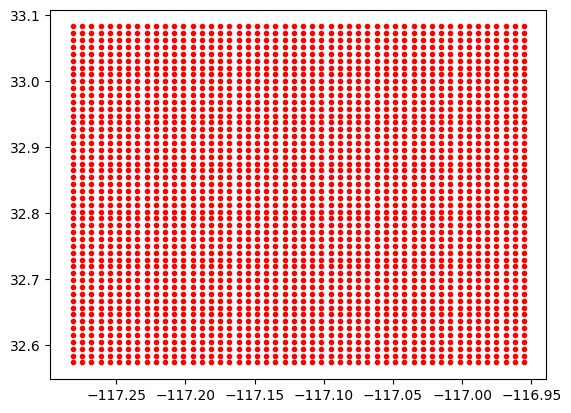

In [7]:
plt.plot(x,y,".", color="red");

In [8]:
grid_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=x.flatten(), y=y.flatten()))

<Axes: >

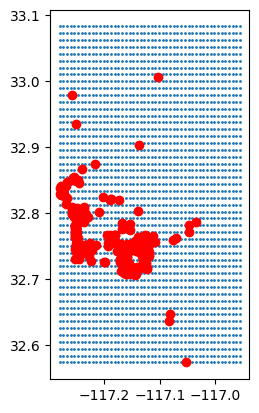

In [9]:
ax = grid_df.plot(markersize=1)
two_bed_homes.plot(ax=ax, color='red')

### Inverse Distance Weighted (IDW)
La técnica IDW calcula un valor promedio para las ubicaciones no muestreadas utilizando valores de ubicaciones cercanas ponderadas. Los pesos son proporcionales a la proximidad de los puntos muestreados a la ubicación no muestreada y pueden ser especificados por el coeficiente de potencia IDW.

$\hat{Z_j} = \frac{\sum_i{Z_i/d^n_{ij}}}{\sum_i{1/d^n_{ij}}}$

Entonces, un valor grande de $n$ hace que los puntos cercanos ejerzan una influencia mucho mayor en la ubicación no muestreada que un punto más alejado, lo que resulta en un resultado interpolado que se asemeja a una interpolación de Thiessen. Por otro lado, un valor muy pequeño de $n$ dará a todos los puntos dentro del radio de búsqueda un peso igual, de modo que todas las ubicaciones no muestreadas representarán nada más que los valores medios de todos los puntos muestreados dentro del radio de búsqueda.


<center><img src="http://www.geography.hunter.cuny.edu/~jochen/GTECH361/lectures/lecture10/3Dconcepts/Inverse%20Distance%20Weighted_files/image001.gif" width="700"></center>

In [10]:
model = KNeighborsRegressor(n_neighbors=5, weights='distance')
model.fit(two_bed_home_locations, two_bed_homes.price)

KNeighborsRegressor(weights='distance')

In [11]:
grid = np.column_stack((x.flatten(), y.flatten()))
predictions = model.predict(grid)

<Axes: >

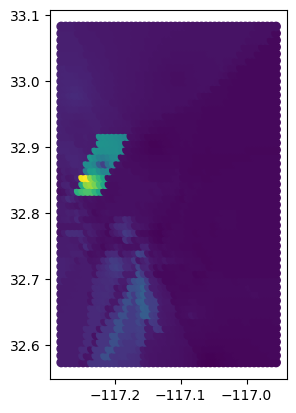

In [12]:
grid_df.plot(predictions)

### Poligonos de Delaunay

In [13]:
from scipy.spatial import Delaunay
tri = Delaunay(two_bed_home_locations)

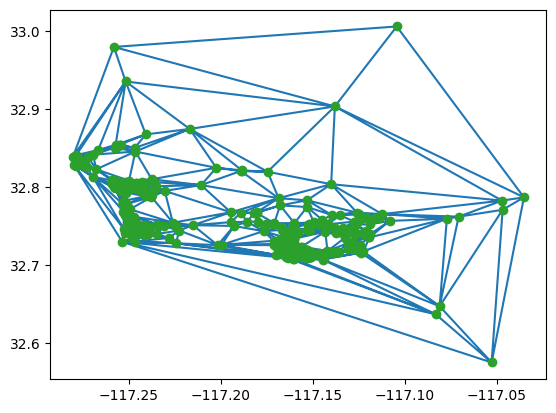

In [14]:
import matplotlib.pyplot as plt
plt.triplot(two_bed_home_locations[:,0], two_bed_home_locations[:,1], tri.simplices)
plt.plot(two_bed_home_locations[:,0], two_bed_home_locations[:,1], 'o');

### Poligonos de Voronoy

In [15]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(two_bed_home_locations)

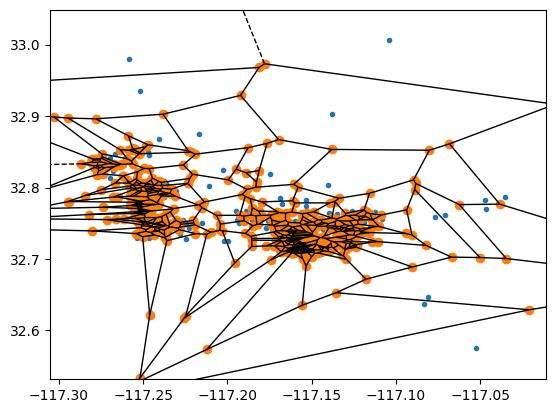

In [16]:
fig = voronoi_plot_2d(vor)

## Kriging
Existen varias formas de interpoladores kriging: ordinario, universal y simple, por nombrar algunos. Esta sección se centrará en la interpolación por kriging ordinario (OK). Esta forma de kriging generalmente involucra cuatro pasos:

* Eliminar cualquier tendencia espacial en los datos.
* Calcular el variograma experimental, γ, que es una medida de la autocorrelación espacial.
* Definir un modelo de variograma experimental que mejor caracterice la autocorrelación espacial en los datos.
* Interpolar la superficie utilizando el variograma experimental.
* Agregar la superficie interpolada por kriging a la superficie interpolada por tendencia para producir el resultado final.

Nos interesa cómo varían estos valores de atributo a medida que aumenta la distancia entre pares de puntos de ubicación. Podemos calcular la diferencia, $γ$, en los valores al cuadrar sus diferencias y luego dividir por 2.


<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f13-two-sites-1.png" width="1000"></center>

El variograma relaciona las distancias de separación por pares de las `coordenadas` y las relaciona con la *semivarianza* de los pares de `valores` correspondientes. El estimador predeterminado utilizado es el estimador de Matheron:


$$ \gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i + h}))^2 $$
							$\gamma = \frac{(Z_2 - Z_1)^2}{2} = \frac{(-1.2 - (1.6))^2}{2} = 3.92$
                            

### Experimental variogram                            
<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-variogram-1.png" width="800"></center>

<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-sample-variogram-1.png" width="800"></center>

### Modelos de Variograma
<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-variogram-models-1.png" width="800"></center>

### Parámetros
<center><img src="https://mgimond.github.io/Spatial/14-Spatial-Interpolation_files/figure-html/f14-model-explained-1.png" width="1000"></center>

 ### Scikit-Gstat
[Scikit-gstat](https://scikit-gstat.readthedocs.io/en/latest/userguide/introduction.html) es un módulo de análisis de geoestadística con un estilo similar a scipy. Incluye dos clases base: Variogram y OrdinaryKriging. Adicionalmente, se encuentran disponibles diversas clases de variogramas que heredan de Variogram para resolver tareas relacionadas con la dirección o espacio-tiempo. El módulo hace uso de una rica selección de estimadores de semivarianza y funciones de modelos de variogramas, mientras que sigue siendo extensible.


In [17]:
!pip install scikit-gstat

In [18]:
import skgstat as skg
from skgstat import Variogram, OrdinaryKriging
import pandas as pd

In [19]:
data = pd.read_csv('https://raw.githubusercontent.com/mmaelicke/scikit-gstat/master/docs/data/sample_sr.csv')
data.head(2)

,x,y,z
0,94,20,-0.394444
1,82,37,-2.283663


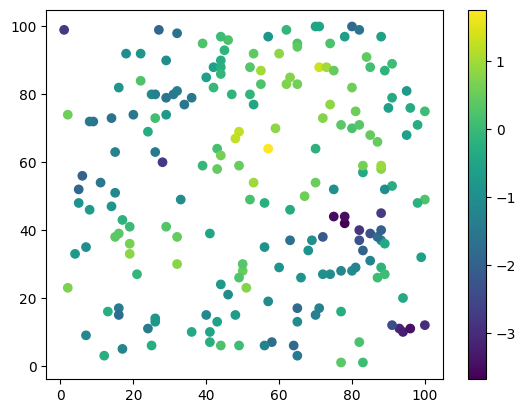

In [20]:
plt.scatter(data.x, data.y, c=data.z)
plt.colorbar()

Ya podemos ver mucho desde aquí:

* Los valores pequeños parecen concentrarse en la esquina superior izquierda y en la esquina inferior derecha.
* Los valores más grandes están dispuestos como una banda desde la esquina inferior izquierda hasta la esquina superior derecha.

La clase [Variogram](https://scikit-gstat.readthedocs.io/en/latest/reference/variogram.html) requiere al menos dos argumentos: las coordenadas y los valores observados en esas ubicaciones. También se debe establecer explícitamente el parámetro `normalize`, ya que en la versión 0.2.8 su valor predeterminado cambia a `False`. Este atributo afecta únicamente el trazado, no los valores del variograma. Además, el número de bins se establece en 20, ya que tenemos bastantes observaciones y el valor predeterminado de 10 es innecesariamente pequeño. El parámetro `maxlag` establece la distancia máxima para el último bin. Sabemos por el gráfico anterior que valores mayores a 60 unidades no son realmente significativos. Para más detalles, por favor consulta la [Guía del Usuario](https://mmaelicke.github.io/scikit-gstat/userguide/variogram.html#experimental-variograms) y el [Libro](https://mmaelicke.github.io/scikit-gstat/SciKitGStat.pdf).


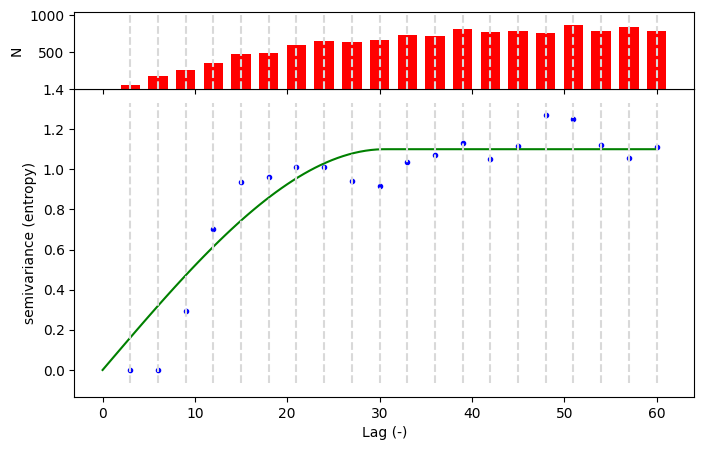

In [21]:
V = Variogram(data[['x', 'y']].values, data.z.values, estimator="entropy", model="spherical", maxlag=60, n_lags=20)
V.plot();

In [22]:
print(V.describe())

{'model': 'spherical', 'estimator': 'entropy', 'dist_func': 'euclidean', 'normalized_effective_range': 1834.26922557867, 'normalized_sill': 1.3943088515026683, 'normalized_nugget': 0, 'effective_range': 30.571153759644503, 'sill': 1.0997281090664, 'nugget': 0, 'params': {'estimator': 'entropy', 'model': 'spherical', 'dist_func': 'euclidean', 'bin_func': 'even', 'normalize': False, 'fit_method': 'trf', 'fit_sigma': None, 'use_nugget': False, 'maxlag': 60, 'n_lags': 20, 'verbose': False}, 'kwargs': {}}


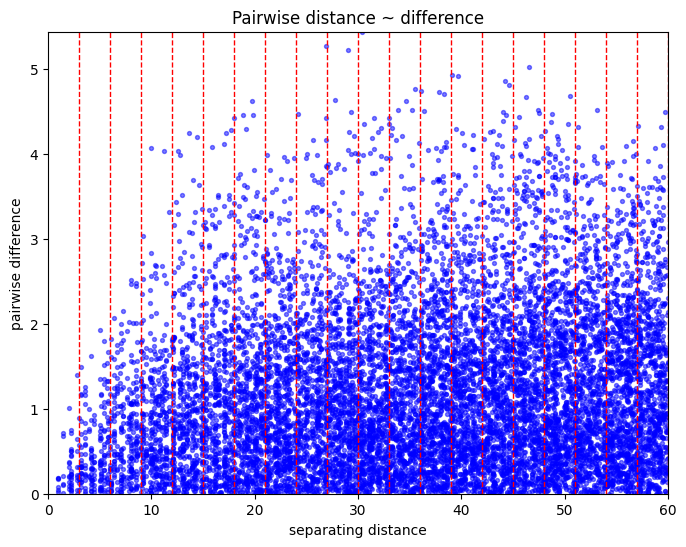

In [23]:
V.distance_difference_plot();

(array([ 96., 191., 285., 378., 466., 516., 625., 610., 619., 714., 705.,
        717., 802., 756., 752., 793., 837., 761., 836., 760.]),
 array([ 1.  ,  3.95,  6.9 ,  9.85, 12.8 , 15.75, 18.7 , 21.65, 24.6 ,
        27.55, 30.5 , 33.45, 36.4 , 39.35, 42.3 , 45.25, 48.2 , 51.15,
        54.1 , 57.05, 60.  ]),
 <BarContainer object of 20 artists>)

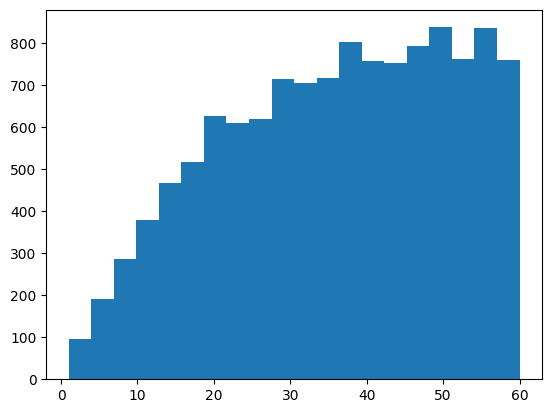

In [24]:
# apply binning
bin, _ = skg.binning.even_width_lags(V.distance, 20, None)

# get the histogram
plt.hist(V.distance,bins=20)

El subgráfico superior muestra el histograma del conteo de pares de puntos en cada clase de retraso (lag). Se pueden observar varias cosas aquí:

Como era de esperarse, existe una clara dependencia espacial, ya que la semivarianza aumenta con la distancia (puntos azules).
El modelo de variograma esférico predeterminado está bien ajustado a los datos experimentales.
La forma de la dependencia no se captura del todo bien, pero es suficientemente aceptable para este ejemplo.

El valor de meseta (sill) del variograma debería corresponder con la varianza del campo. El campo es desconocido, pero podemos comparar la meseta con la varianza de la muestra:


In [25]:
print(data.z.var()) #sample variance
V.describe()['sill'] # Variogram sill

1.1043879677736883


1.0997281090664

La clase `Kriging` ahora usará el Variograma de arriba para estimar los pesos de Kriging para cada celda de la cuadrícula. Esto se realiza resolviendo un sistema de ecuaciones lineales. Para una ubicación no observada $s_0$, podemos usar las distancias a 5 puntos de observación y construir el sistema de la siguiente manera:

$$
\begin{pmatrix}
\gamma(s_1, s_1) & \gamma(s_1, s_2) & \gamma(s_1, s_3) & \gamma(s_1, s_4) & \gamma(s_1, s_5) & 1\\
\gamma(s_2, s_1) & \gamma(s_2, s_2) & \gamma(s_2, s_3) & \gamma(s_2, s_4) & \gamma(s_2, s_5) & 1\\
\gamma(s_3, s_1) & \gamma(s_3, s_2) & \gamma(s_3, s_3) & \gamma(s_3, s_4) & \gamma(s_3, s_5) & 1\\
\gamma(s_4, s_1) & \gamma(s_4, s_2) & \gamma(s_4, s_3) & \gamma(s_4, s_4) & \gamma(s_4, s_5) & 1\\
\gamma(s_5, s_1) & \gamma(s_5, s_2) & \gamma(s_5, s_3) & \gamma(s_5, s_4) & \gamma(s_5, s_5) & 1\\
1 & 1 & 1 & 1 & 1 & 0 \\
\end{pmatrix} *
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\lambda_3 \\
\lambda_4 \\
\lambda_5 \\
\mu \\
\end{bmatrix} =
\begin{pmatrix}
\gamma(s_0, s_1) \\
\gamma(s_0, s_2) \\
\gamma(s_0, s_3) \\
\gamma(s_0, s_4) \\
\gamma(s_0, s_5) \\
1 \\
\end{pmatrix}
$$

En consecuencia, la clase `OrdinaryKriging` necesita un objeto `Variogram` como atributo obligatorio. Dos atributos opcionales muy importantes son `min_points` y `max_points`, los cuales limitan el tamaño del sistema de ecuaciones de Kriging. Como tenemos 200 observaciones, podemos requerir al menos 5 vecinos dentro del rango. Más de 15 solo ralentizaría innecesariamente la computación. El atributo `mode='exact'` indicará a la clase que construya y resuelva el sistema anterior para cada ubicación.


In [26]:
ok = OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

El método `transform` aplicará la interpolación para los arreglos de coordenadas pasados. Requiere cada dimensión como un solo arreglo 1D. Podemos fácilmente construir una malla (meshgrid) de 100x100 coordenadas y pasarlas al interpolador. Para recibir un resultado en 2D, simplemente podemos reestructurar el resultado. El error de Kriging estará disponible como el atributo `sigma` del interpolador.


In [27]:
# build the target grid
xx, yy = np.mgrid[0:99:100j, 0:99:100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

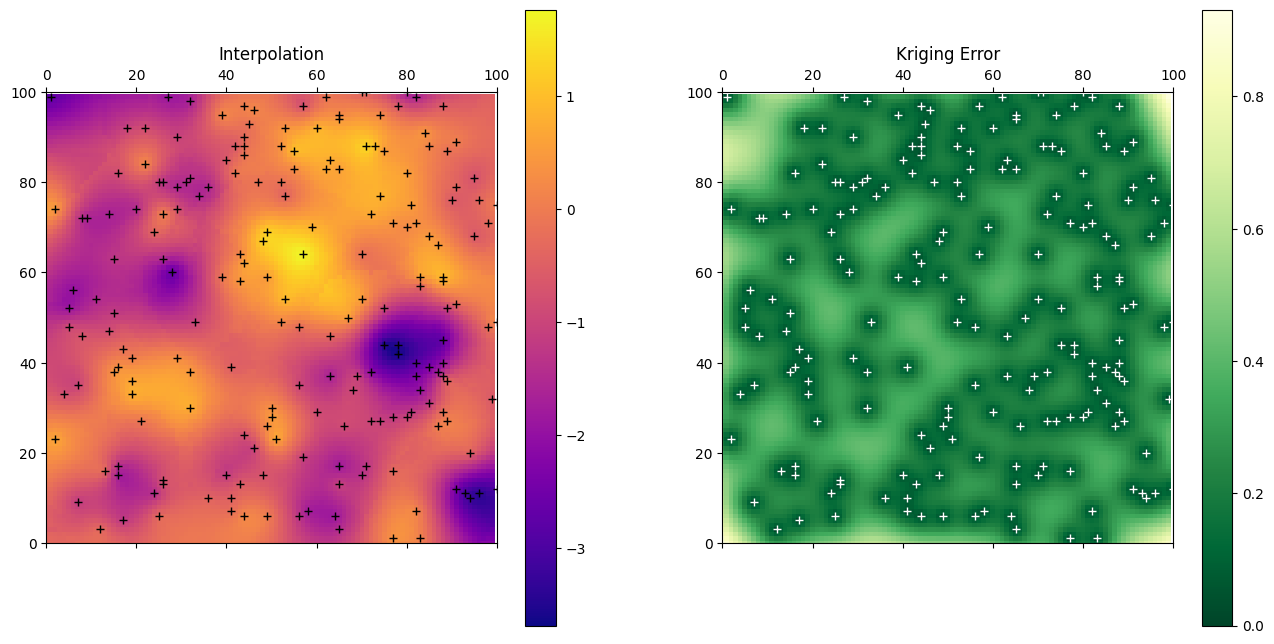

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

art = axes[0].matshow(field.T, origin='lower', cmap='plasma')
axes[0].set_title('Interpolation')
axes[0].plot(data.x, data.y, '+k')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(data.x, data.y, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

### Pykrige

In [29]:
!pip install pykrige

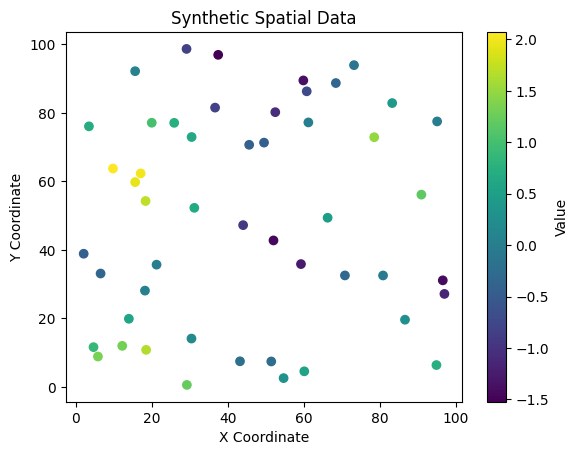

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate synthetic data: 50 points
np.random.seed(42)  # For reproducibility
x_coords = np.random.uniform(0, 100, 50)
y_coords = np.random.uniform(0, 100, 50)
values = np.sin(x_coords * 0.1) + np.cos(y_coords * 0.1) + np.random.normal(0, 0.1, 50)

# Plotting the synthetic data
plt.scatter(x_coords, y_coords, c=values, cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Synthetic Spatial Data')
plt.show()

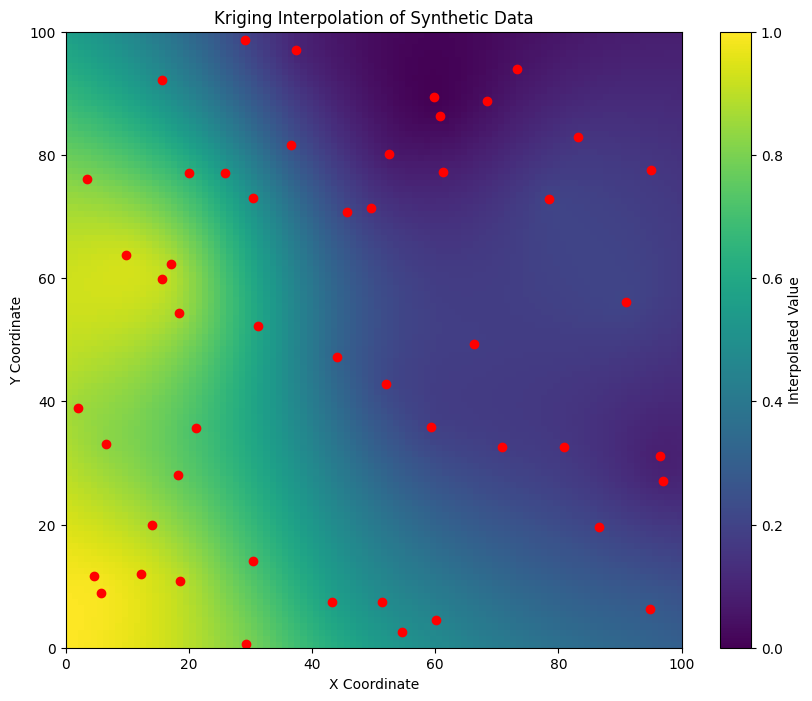

In [31]:
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt

# Create the Ordinary Kriging object
OK = OrdinaryKriging(
    x_coords,
    y_coords,
    values,
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)

# Generate a grid
gridx = np.linspace(0, 100, 100)
gridy = np.linspace(0, 100, 100)

# Perform kriging
z, ss = OK.execute('grid', gridx, gridy)

# z is the interpolated values
# ss is the squared error
plt.figure(figsize=(10, 8))
plt.imshow(z, extent=(0, 100, 0, 100), origin='lower', cmap='viridis')
plt.scatter(x_coords, y_coords, c='red')  # original data points
plt.colorbar(label='Interpolated Value')
plt.title('Kriging Interpolation of Synthetic Data')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()